In [1]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [2]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()
       
        m2      = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm2, ym2  = m2(LON, LAT)
        im2     = m2.plot(xm2,ym2,'.', color='k',linewidth=2.)

        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

In [3]:
def investigate_traj(figsize, proj, nb_traj, hfacc_level):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.basemap import Basemap
    import cmocean
    
    fig     = plt.figure(figsize=figsize)
    
    if proj=='ortho':
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0, resolution="l")
    elif proj=='merc':
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-40.,llcrnrlon=120.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
    elif proj=='lamb':
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
            
    # Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
    xm, ym  = m(Xf, Yf)
    im      = m.contourf(xm, ym, hFacC[hfacc_level,...], extend='both', cmap='Greys_r')
    
    # Plot the salinity
    #xm, ym  = m(XC, YC)
    #im      = m.contourf(xm, ym, mean_Salt_30, levels=np.linspace(32.8,35.3,50), extend='both', cmap=cmocean.cm.haline)
    #cbar    = m.colorbar(im,pad='10%')
    #cbar.set_label('Salinity', fontsize =16)
    
    # Plot the stream function
    xm, ym  = m(XC, YC)
    cs      = m.contour(xm, ym, SF, extend='both', levels=np.linspace(np.nanmin(SF), np.nanmax(SF), 10), colors='k', linewidth=0.3)
    plt.clabel(cs, inline=True, fontsize=8)
    
    # Plot the southern front
    xm, ym  = m(XC, YC)
    im      = m.contour(xm, ym, southern_front)
    
    # Plot all the traj
    for p in nb_traj: 
        #xm, ym  = m(LON[:,p], LAT[:,p])
        #im      = m.plot(xm, ym, '-', color='orange',linewidth=0.4)
        xm, ym  = m(LON[0,p], LAT[0,p])
        im      = m.plot(xm, ym, '.', color='b',linewidth=2.)
        #xm, ym  = m(LON[-1,p], LAT[-1,p])
        #im      = m.plot(xm, ym, '*', color='r',linewidth=3.)
        
    # Plot the southern front
    xm, ym  = m(XC, YC)
    im      = m.contour(xm, ym, southern_front)
        
    m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
    #plt.title('10 000 parti, 5 years (hFacC and S at 30 m)', fontsize=18)
    #plt.savefig(path_save + title_save, bbox_inches='tight')

In [4]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

In [5]:
# Mercator salinity
mean_Salt_surf = pickle_load('mean_Salt_surf_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_30     = pickle_load('mean_Salt_30_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_100   = pickle_load('mean_Salt_100_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_200   = pickle_load('mean_Salt_200_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_500   = pickle_load('mean_Salt_500_2', '/data/ebent/Bigger_domain/', verbose=False)

# Mercator temperature
mean_Theta_surf = pickle_load('mean_Theta_surf_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_30     = pickle_load('mean_Theta_30_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_100   = pickle_load('mean_Theta_100_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_200   = pickle_load('mean_Theta_200_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_500   = pickle_load('mean_Theta_500_2', '/data/ebent/Bigger_domain', verbose=False)

In [6]:
SF = pickle_load('SF_2', '/data/ebent/', verbose=False)

In [7]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [8]:
# This is hFacC for the SOUTHERN HEMISPHERE

file_h = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file_h.get('hFacC')
hFacC = np.array(hFacC)
Xf = file_h.get('XC')
Xf = np.array(Xf)
Yf = file_h.get('YC')
Yf = np.array(Yf)

In [9]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"
lon_min   = 1440 
lon_max   = 3241
lat_min   = 0 
lat_max   = 1024

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04
XC, YC    = np.meshgrid(XC, YC)

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

In [10]:
southern_front = pickle_load('ACC_southern_front', '/data/ebent/', verbose=False)
southern_front = np.ma.masked_array(southern_front, mask=False)

In [11]:
W_boundary = 12 # 121,04 degrees
E_boundary = 1560 # 250,04 degrees

In [12]:
# Create a meshgrid to plot in index coordinates
xc = np.arange(1801)
yc = np.arange(1024)
xc, yc = np.meshgrid(xc,yc)

In [13]:
npts = 10000

***

# Load variables

In [14]:
path = '/data/ebent/Octopus/output/255m_line_RG/'

In [15]:
NPP = 'NPP01'

In [16]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_xround.npy')


In [17]:
Z1 = pickle_load(NPP + '_Z1', path)
Z2 = pickle_load(NPP + '_Z2', path)
Z3 = pickle_load(NPP + '_Z3', path)
Z4 = pickle_load(NPP + '_Z4', path)
Z5 = pickle_load(NPP + '_Z5', path)
dead = pickle_load(NPP + '_dead', path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z1.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z2.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z3.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z4.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z5.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_dead.npy')


In [18]:
dead = dead-dead[0]

***

# Plots

# Definition of the different zones

In [14]:
look_index = np.where(southern_front[:,W_boundary]==0)[0]
look_index2 = np.where(southern_front[:,E_boundary]==0)[0]

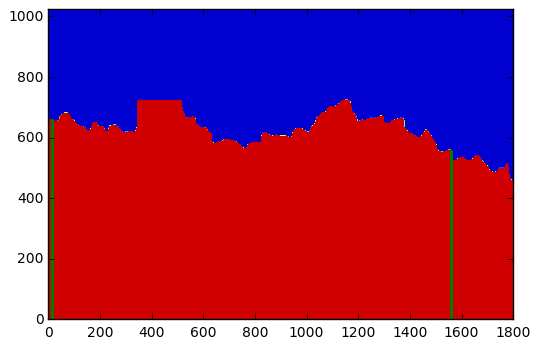

In [16]:
plt.contourf(xc, yc, southern_front)
tmp = np.ones(look_index[0])*W_boundary
tmp2 = np.ones(look_index2[0])*E_boundary
plt.plot(tmp, yc[:look_index[0],:], '-g')
plt.plot(tmp2, yc[:look_index2[0],:], '-g')
plt.show()

***

In [20]:
Path = '/data/ebent/Octopus/output/255m_line_RG/'

In [21]:
Ind_parti_north = pickle_load('Ind_parti_north', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Ind_parti_north.npy')


In [24]:
import itertools
all_ind = []
npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for NPP in npp:
    all_ind.append(Ind_parti_north[NPP])
    
ind_parti_north = list(itertools.chain(*all_ind))

Used NPP01 for these two plots

/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


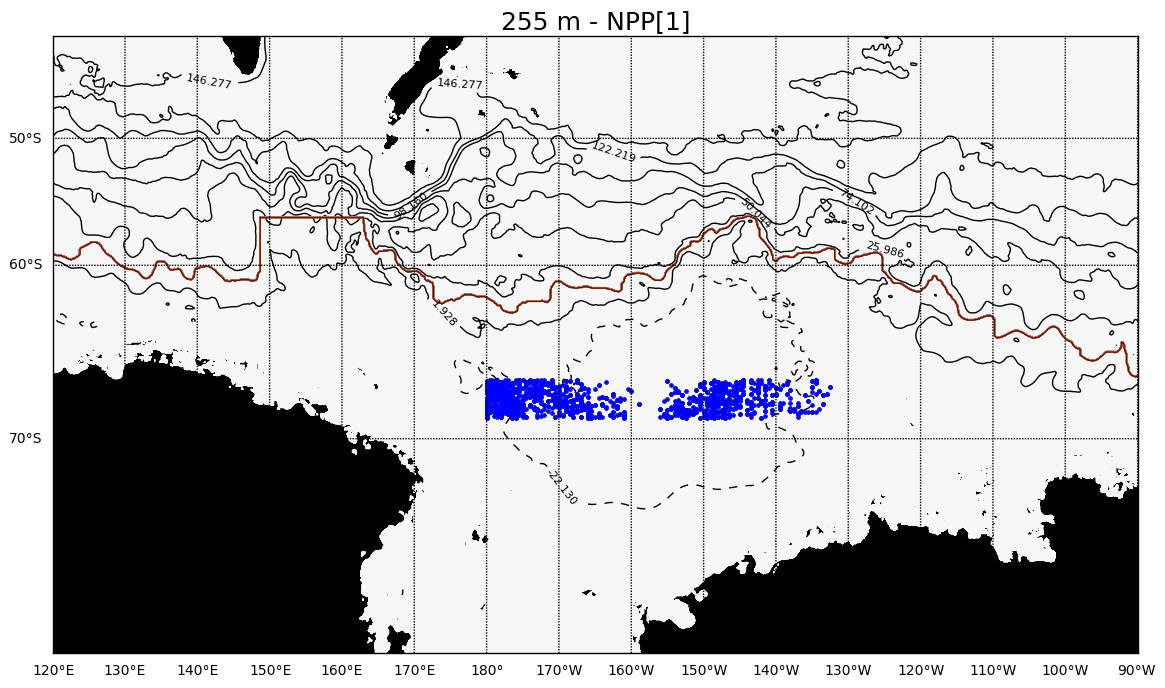

In [27]:
# Initial pos of particles that go north
investigate_traj(figsize=(14,10), proj='merc', nb_traj=ind_parti_north, hfacc_level=44)
plt.title('255 m - NPP[1]', fontsize=18)

NameError: global name 'LAT' is not defined

/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


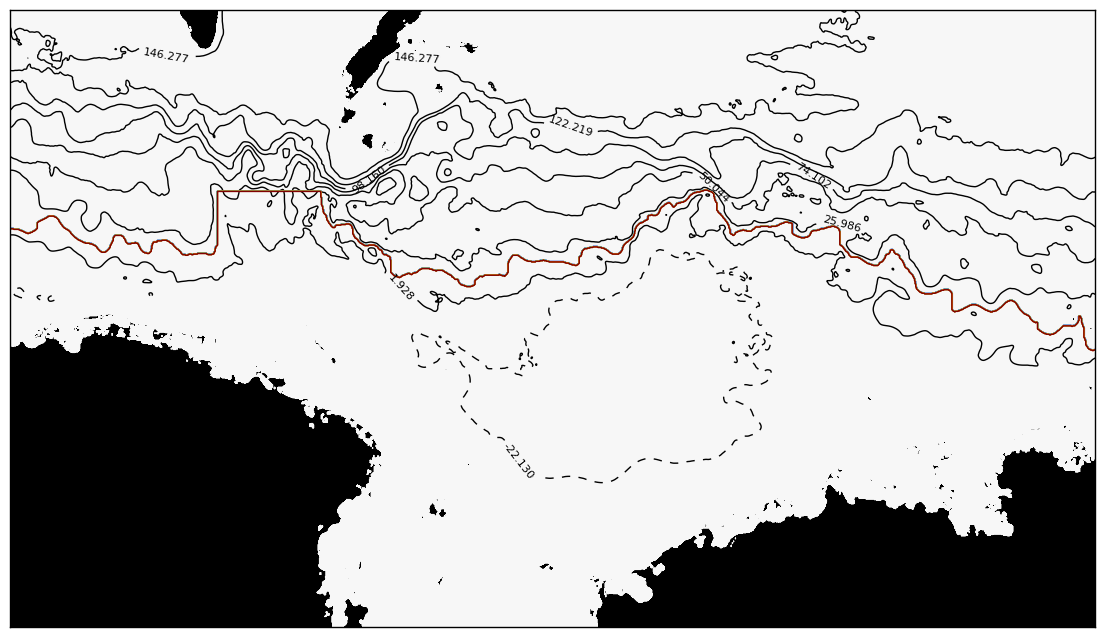

In [83]:
# Initial positions of all particles
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(10000), hfacc_level=44)
plt.title('255 m - NPP[1]', fontsize=18)

***

# Plot of the traj of the experiment 

In [210]:
XC, YC    = np.meshgrid(XC, YC)

BEFORE mask of wrong initialisation

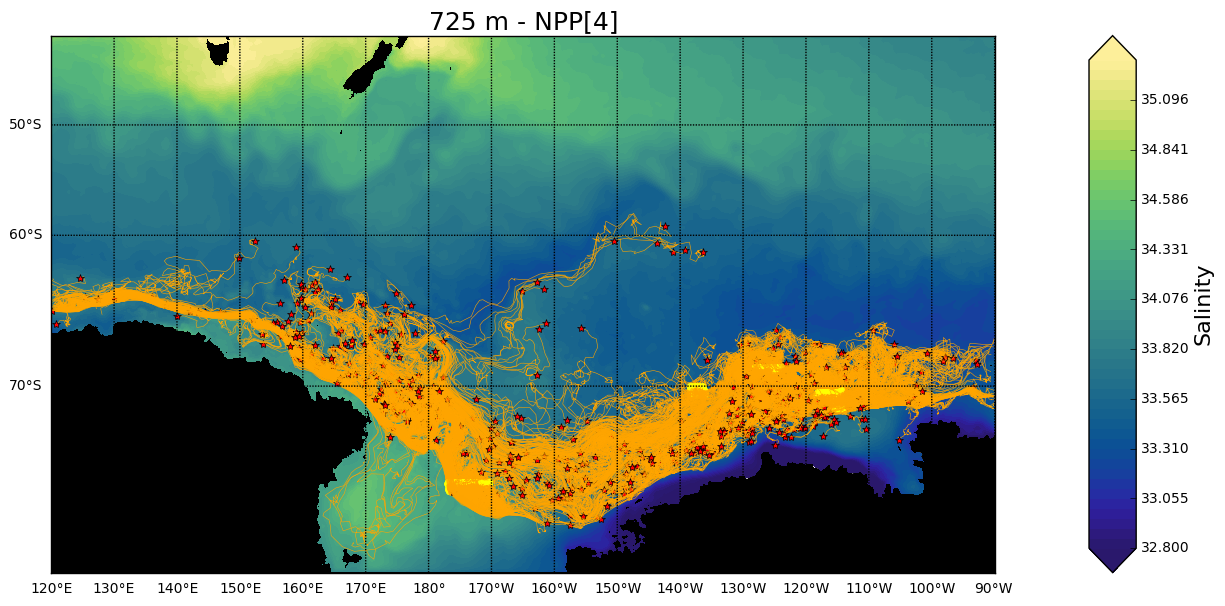

In [90]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

AFTER mask of wrong initialisation

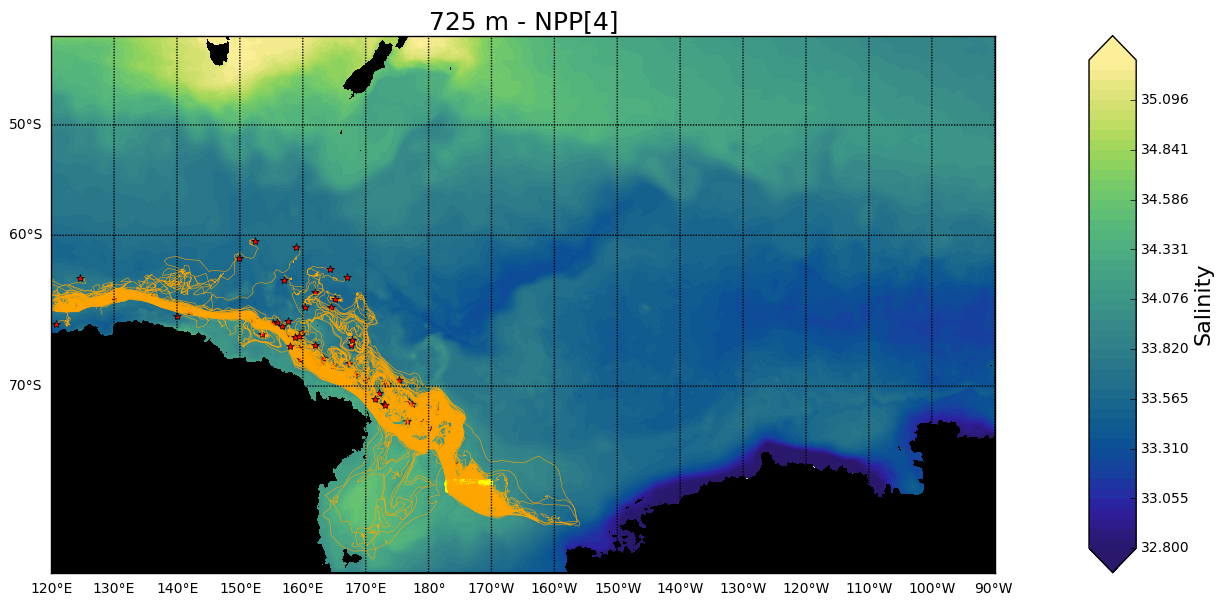

In [244]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(1000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

# Why do some go east ?

Plot of all the parti

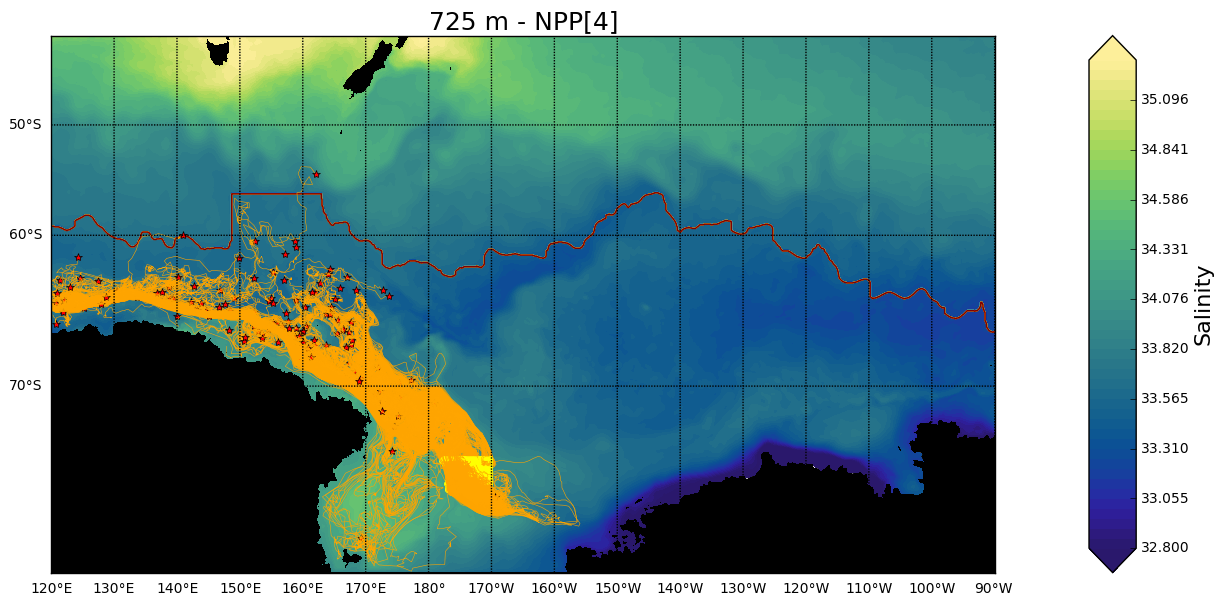

In [56]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(3000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

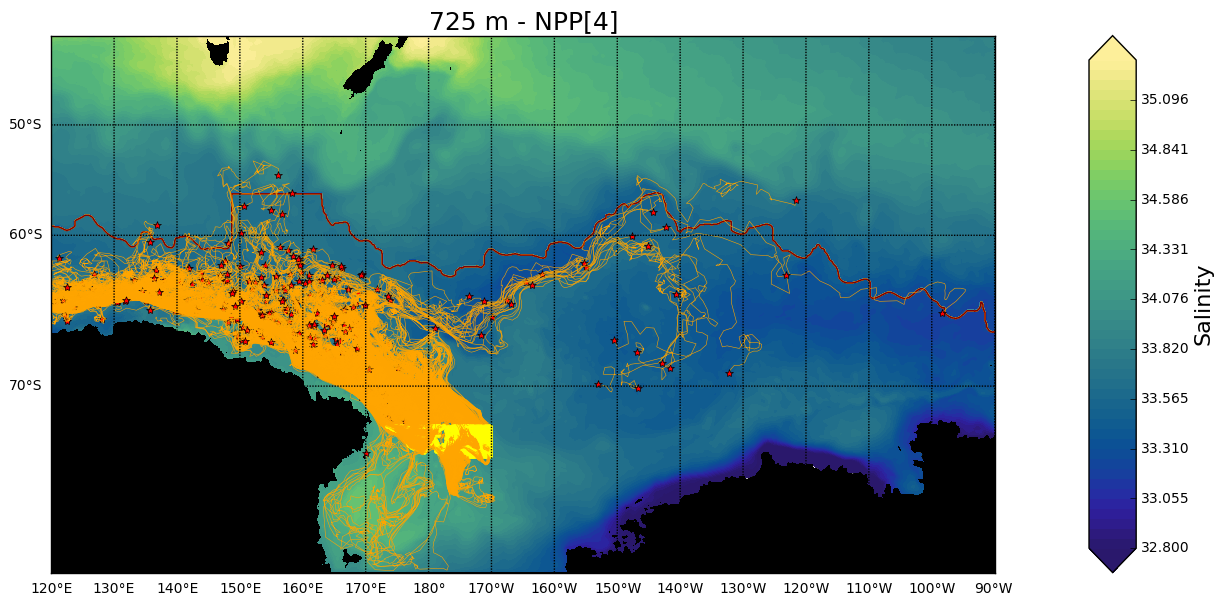

In [60]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(3000,6000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

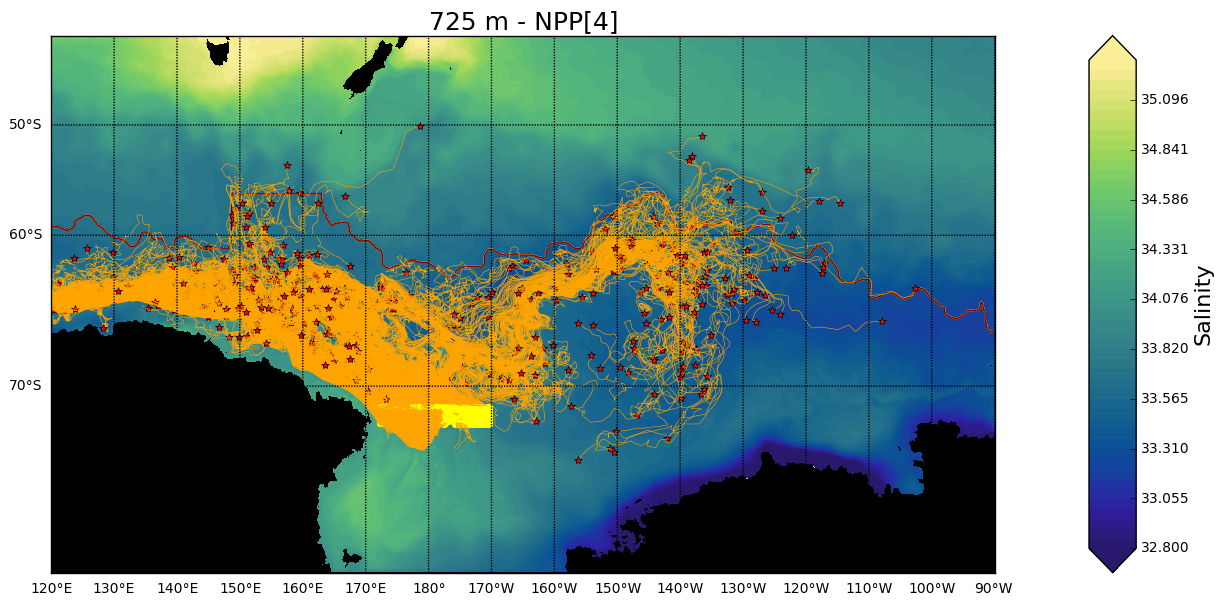

In [58]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(6000,8000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

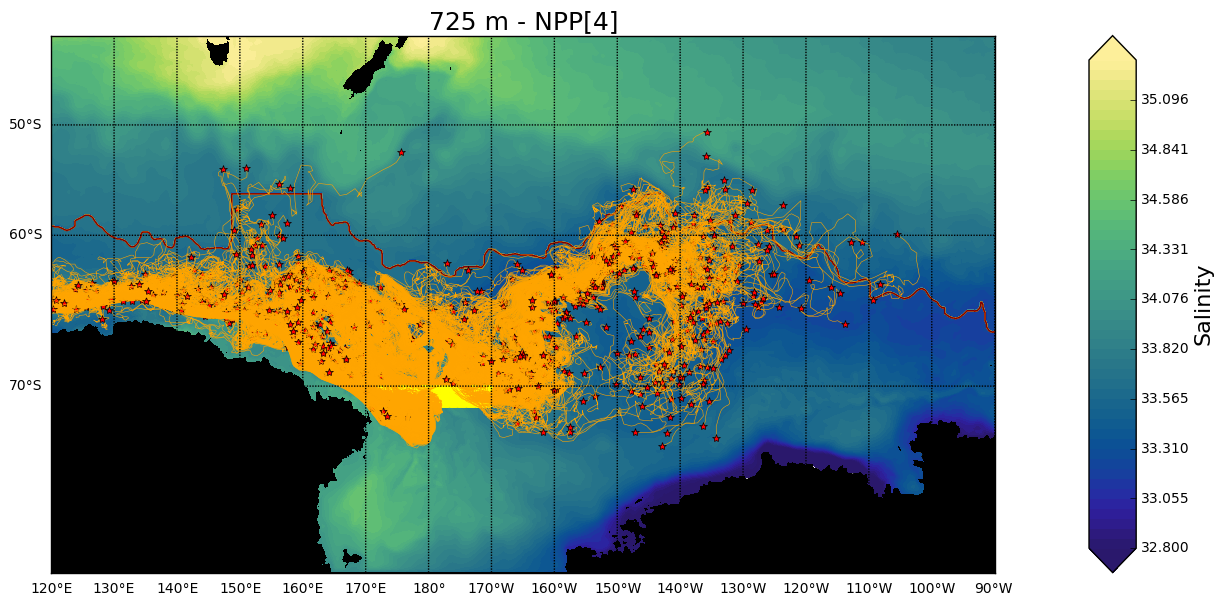

In [61]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(8000,10000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

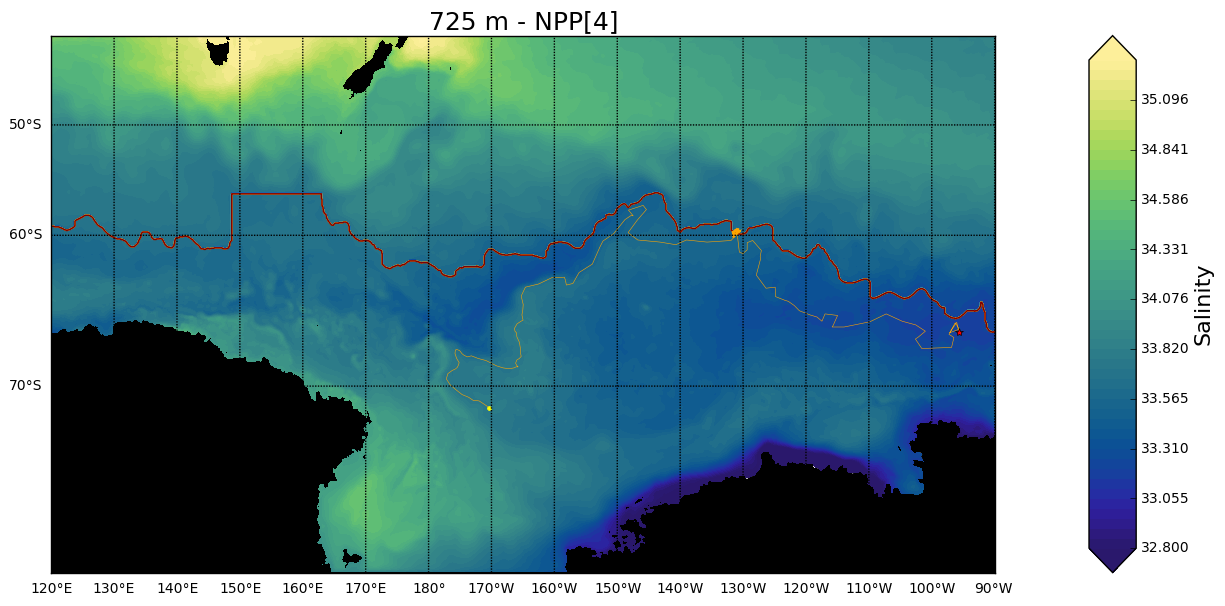

In [39]:
# Particle that goes east and passes north at one point
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(7798, 7799), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

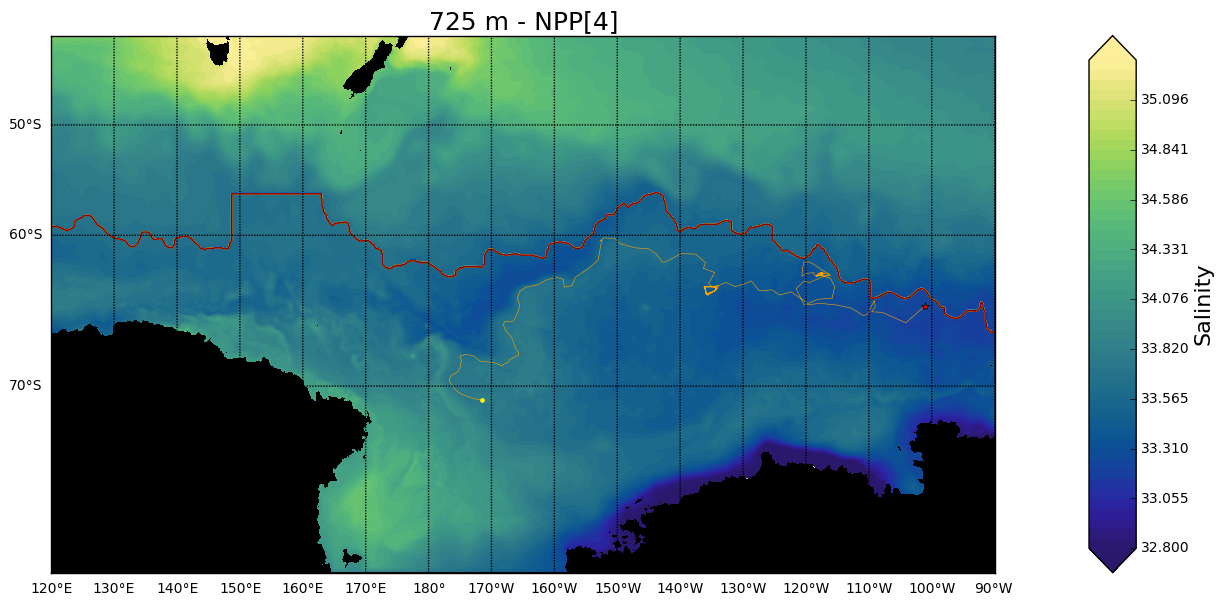

In [38]:
# Particle that goes east
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(8592, 8593), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

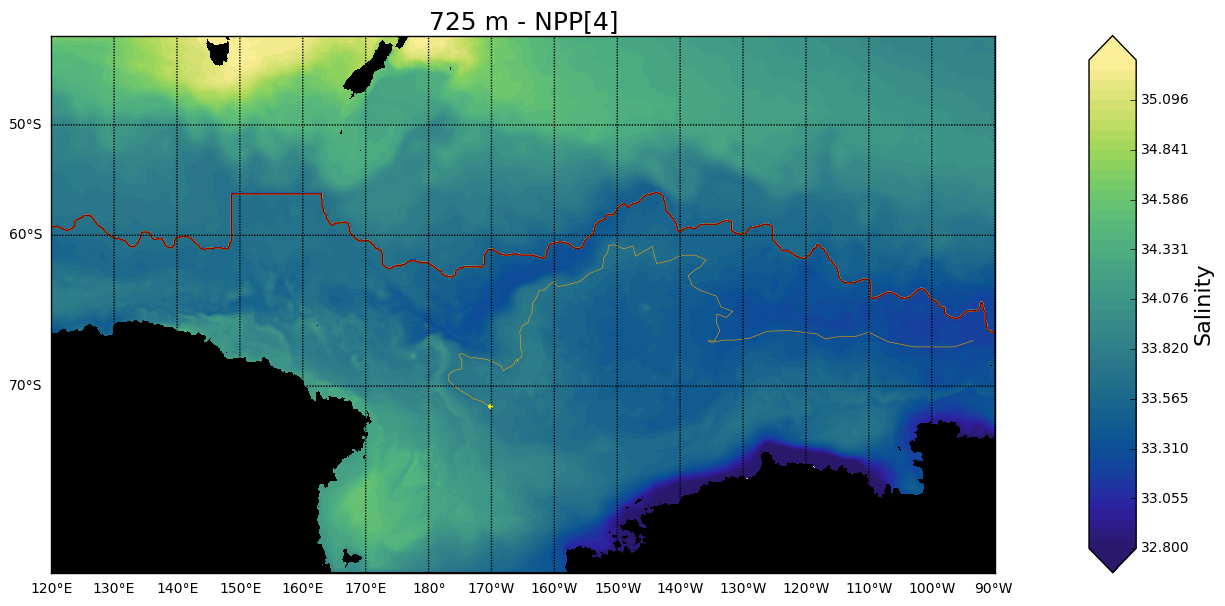

In [41]:
# Particle that goes east
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(7999, 8000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

#### Particles that go East : 11 parti

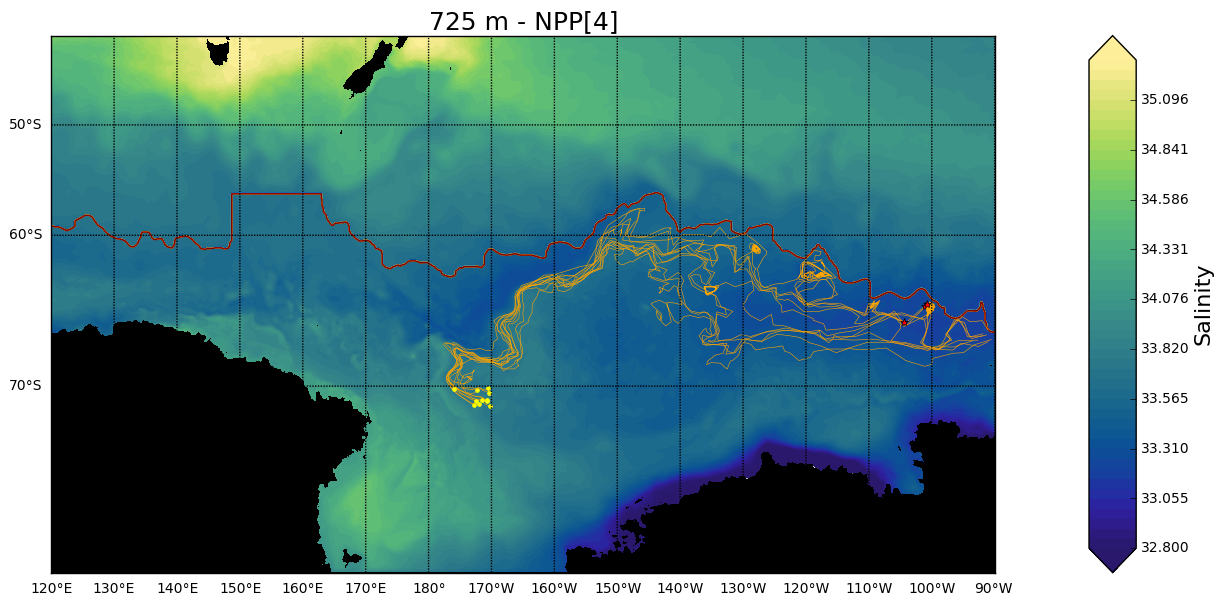

In [44]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=to_east, hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

#### Particles that go West : 1449 parti

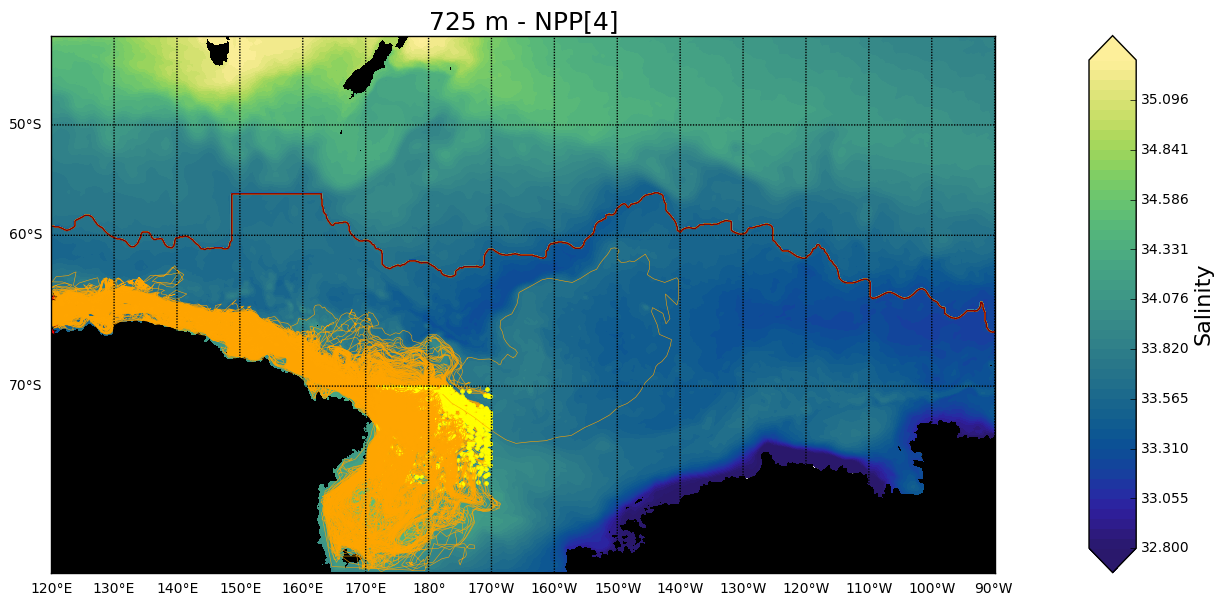

In [52]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=to_west, hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

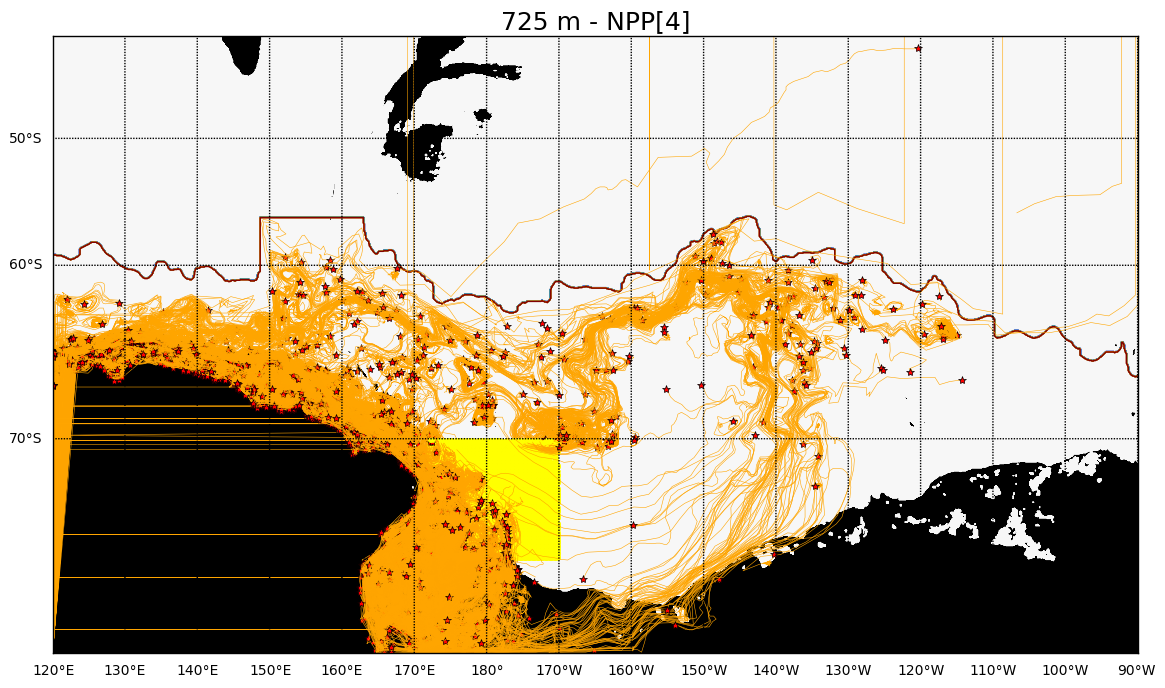

In [211]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=in_RG, hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

In [216]:
len(in_RG)

8085

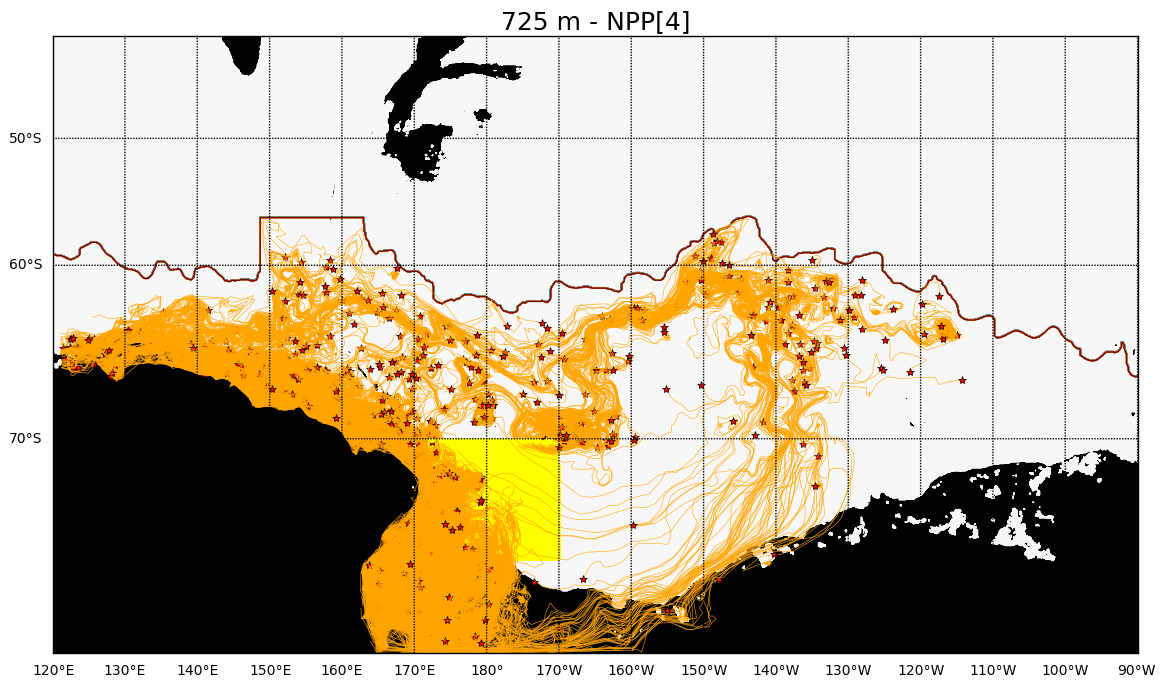

In [215]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=in_RG, hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

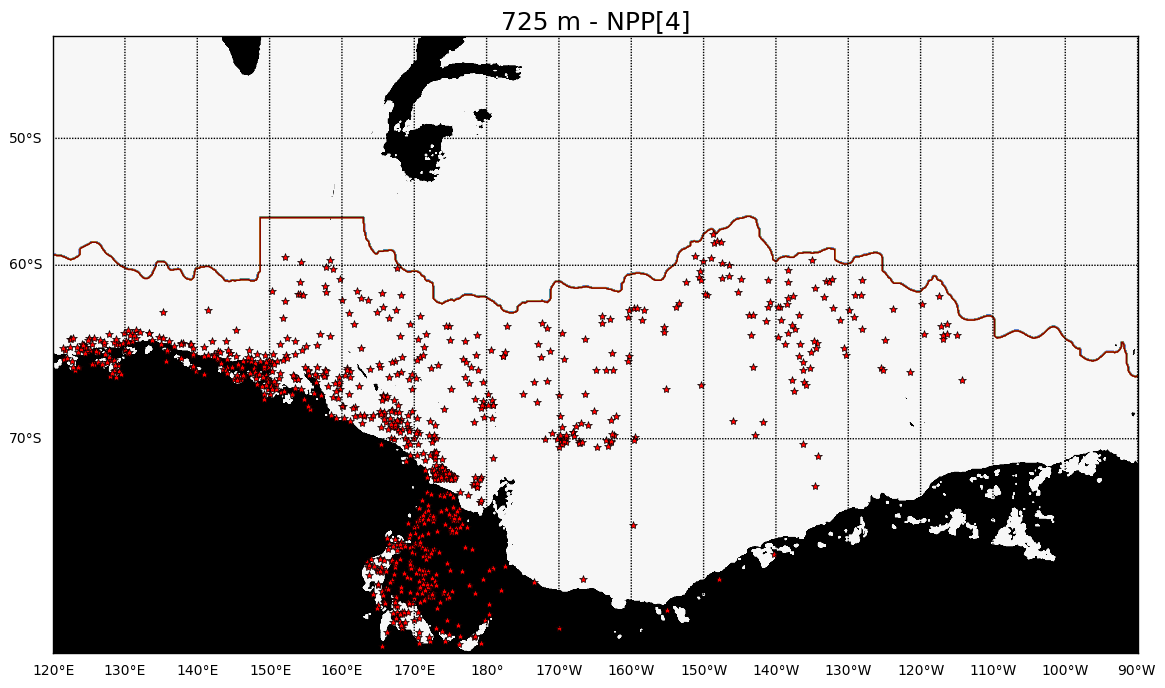

In [218]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=in_RG, hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

# Look at what happens with depth : realistic ?

725 m - NPP4

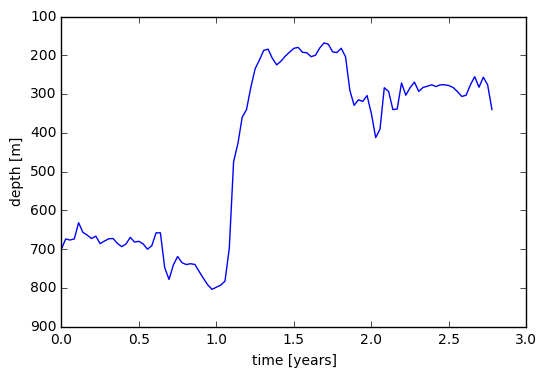

In [44]:
plt.plot(time, DEP[:,972])
plt.xlabel('time [years]')
plt.ylabel('depth [m]')
plt.gca().invert_yaxis()

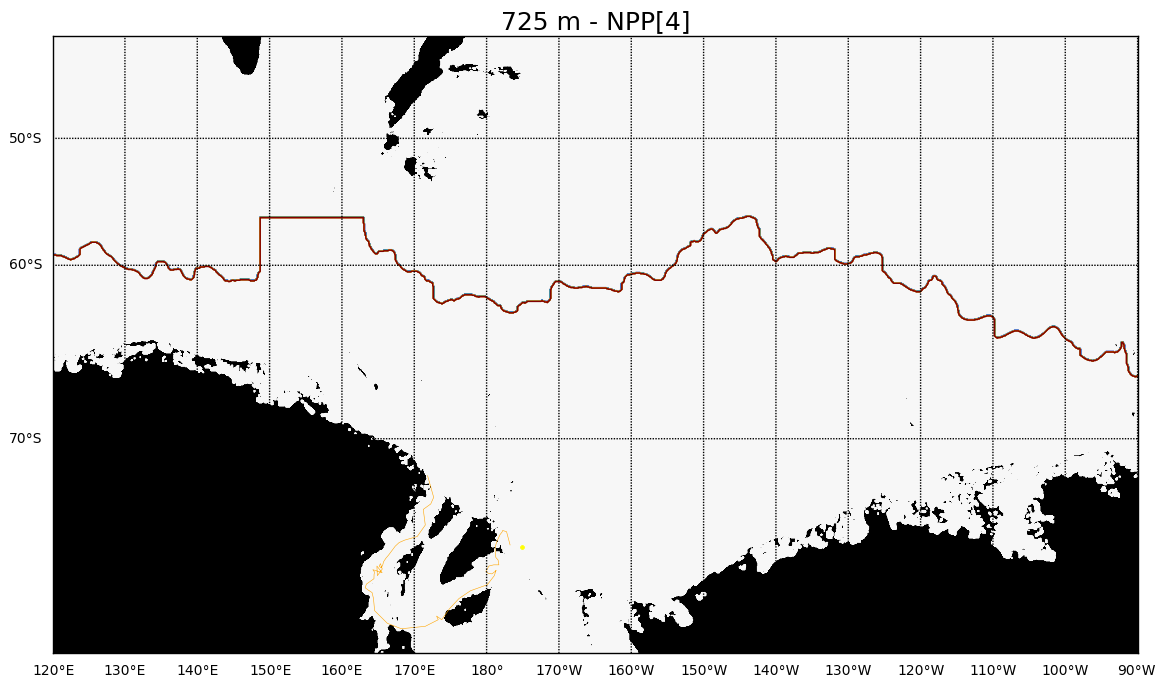

In [54]:
# Particle that goes east
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(972, 973), hfacc_level=55)
plt.title('725 m - NPP[4]', fontsize=18)

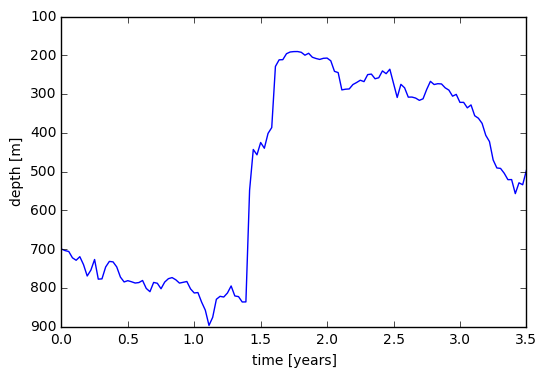

In [45]:
plt.plot(time, DEP[:,371])
plt.xlabel('time [years]')
plt.ylabel('depth [m]')
plt.gca().invert_yaxis()

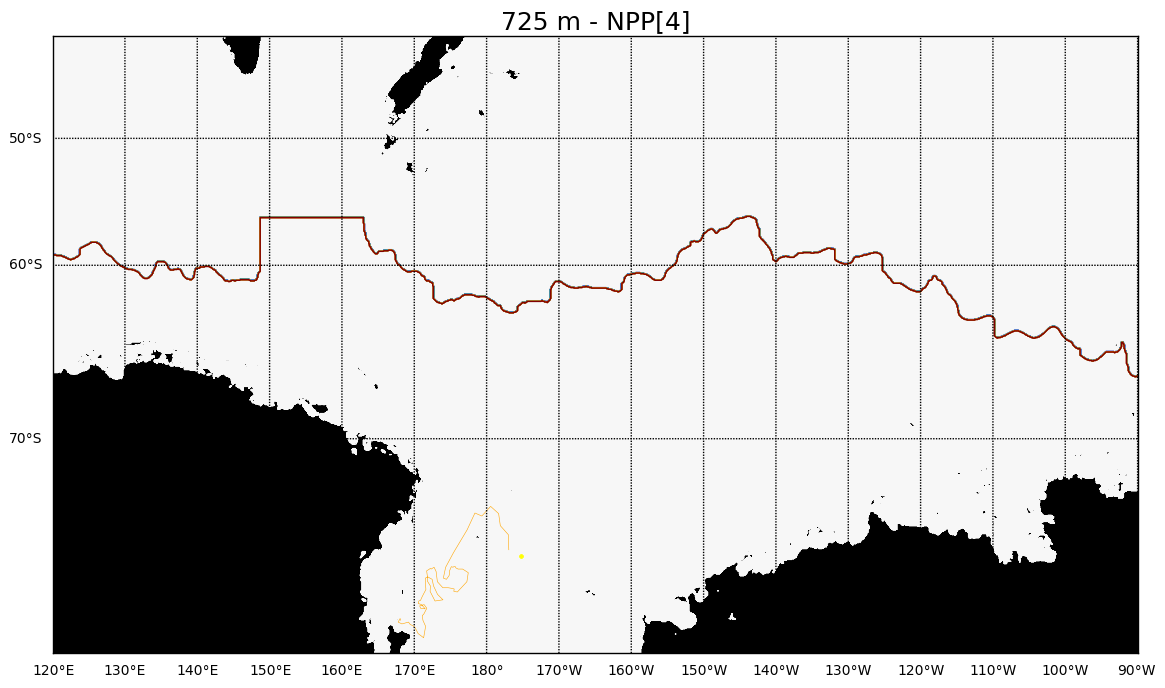

In [61]:
# Particle that goes east
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(371, 372), hfacc_level=37)
plt.title('725 m - NPP[4]', fontsize=18)

***

# Mettre un mask sur les traj

Il a fallut mettre hFacC sur la même taille que mercator, on l'appelle hfacc

In [179]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 178 records
glued data : 30m_12_10_4_0002.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/30m_12_10_4/
Number of parti with z < 0 : 59
Number of parti with z > 103 (bottom of ocean) : 2


/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [180]:
path = '/data/ebent/Octopus/output/30m_12_10_4/'

In [181]:
LON = np.ma.masked_array(lon, mask=False)
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

#x = np.ma.masked_array(xround, mask=False)
#y = np.ma.masked_array(yround, mask=False)
#z = np.ma.masked_array(zround, mask=False)

### Here I put a mask on hfacc==0

In [182]:
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True: 
            continue
        if hfacc[zround[t,p], yround[t,p], xround[t,p]]==0.:
            #print t,p
            LON.mask[t:,p]=True

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti 

In [183]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué
#tmp_p = []
#tmp_t = []
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            #print t,p
            #tmp_p.append(p)
            #tmp_t.append(t)
            LON.mask[t:,p]=True
            break

### Here I mask particles that have an initial pos out of the box I chose (this happens because of the pb of bathymetry in initial pos)

In [184]:
lon_W=172.
lon_E=190.
lat_S=-75.
lat_N=-70.

In [185]:
parti = []
for p in range(LON.shape[1]):
    if LON[0,p]<lon_W or LON[0,p]>lon_E or LAT[0,p]<lat_S or LAT[0,p]>lat_N:
        LON.mask[:,p]=True
        parti.append(p)

In [186]:
len(parti)

100

On applique le mask de LON pour les autres variables

In [190]:
# Make sure all pos have the same mask
LAT.mask = LON.mask
DEP.mask = LON.mask

xround.mask = LON.mask
yround.mask = LON.mask
zround.mask = LON.mask

In [216]:
#x.mask = LON.mask
#y.mask = LON.mask
#z.mask = LON.mask

### Save the positions with masks

In [72]:
NPP = 'NPP01'

In [73]:
pickle_save(NPP + '_DEP', path, DEP)
pickle_save(NPP + '_LAT', path, LAT)
pickle_save(NPP + '_LON', path, LON)

pickle_save(NPP + '_zround', path, zround)
pickle_save(NPP + '_yround', path, yround)
pickle_save(NPP + '_xround', path, xround)

('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_DEP.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LAT.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LON.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_zround.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_yround.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_xround.npy')


***

## Test some specific particles

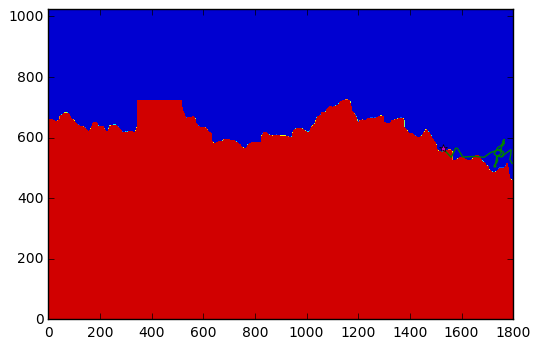

In [225]:
p = 6165
plt.contourf(xc, yc, southern_front)
plt.plot(xround[:,p],yround[:,p], '-g')
plt.plot(xround[0,p],yround[0,p], '*m')
#plt.plot(xround[77:,p],yround[77:,p], '.k')

***

# Count the particles in each zone

In [43]:
are_alive = []

for p in range(10000):
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask
    
    parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
    if parti_are_dead.size>0.:
        are_alive.append(p)

In [44]:
len(are_alive)

6930

In [35]:
def count_in_zones(NPP, xround, yround, zround):
    to_east = []
    to_west = []
    to_north = []
    in_RG = []
    to_west_east = []
    are_dead = []
    
    for p in range(10000):
        south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
        south_front.mask = xround[:,p].mask
        
        north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
        west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=W_boundary))) 
        east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=E_boundary)))
        parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
        
        if north_outside_RG.size==0. and west_outside_RG.size==0. and east_outside_RG.size==0. and parti_are_dead.size>0.:
            in_RG.append(p)
        if north_outside_RG.size>0. and parti_are_dead.size>0.:
            to_north.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size>0. and east_outside_RG.size==0. and parti_are_dead.size>0.:
            to_west.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size==0. and east_outside_RG.size>0. and parti_are_dead.size>0.:
            to_east.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size>0. and east_outside_RG.size>0. and parti_are_dead.size>0.:
            to_west_east.append(p)
        if parti_are_dead.size==0.:
            are_dead.append(p)
            
    print ''
    print 'NPP' + NPP + ' :'
    print ''
    print 'Particles that stay in the Ross Gyre :', len(in_RG)
    print 'Particles that go North :', len(to_north)
    print 'Particles that go West :', len(to_west)
    print 'Particles that go East :', len(to_east)
    print 'Particles that go East then West :', len(to_west_east)
    print 'Particles that are masked :', len(are_dead)
    print 'Total number of particles not dead :', len(in_RG)+len(to_north)+len(to_west)+len(to_east)+len(to_west_east)
    
    return in_RG, to_east, to_north, to_west, to_west_east

In [101]:
for p in range(10000):
    test = np.squeeze(np.array(np.ma.where(xround.mask[:,6000]==True)))
    if len(test)==0:
        print p

In [91]:
xround = pickle_load('NPP' + '04' + '_xround', path, verbose=False)

In [30]:
path = '/data/ebent/Octopus/output/30m_12_10_4/'

In [201]:
npp = ['04']
#npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
n = 1
for NPP in npp:
    DEP = pickle_load('NPP' + NPP + '_DEP', path, verbose=False)
    LAT = pickle_load('NPP' + NPP + '_LAT', path, verbose=False)
    LON = pickle_load('NPP' + NPP + '_LON', path, verbose=False)
    
    zround = pickle_load('NPP' + NPP + '_zround', path, verbose=False)
    yround = pickle_load('NPP' + NPP + '_yround', path, verbose=False)
    xround = pickle_load('NPP' + NPP + '_xround', path, verbose=False)

    in_RG, to_east, to_north, to_west, to_west_east = count_in_zones(NPP)


NPP04 :

Particles that stay in the Ross Gyre : 8085
Particles that go North : 355
Particles that go West : 1449
Particles that go East : 11
Particles that go East then West : 0
Particles that are masked : 100
Total number of particles not dead : 9900


# Particle analysis : count the particles according to time

## This is research

In [104]:
for p in range(4):
    t = 0
    while t<5:
        if t%2:
            t=5
        print p, t, t%2
        t+=1
        

0 0 0
0 5 1
1 0 0
1 5 1
2 0 0
2 5 1
3 0 0
3 5 1


In [26]:
boo = []
buu = []
for x in range(10):
    for y in range(10):
        print 'x =', x, 'y =', y
        if y == 2:
            break
    #boo.append(x)
    #buu.append(y)

x = 0 y = 0
x = 0 y = 1
x = 0 y = 2
x = 1 y = 0
x = 1 y = 1
x = 1 y = 2
x = 2 y = 0
x = 2 y = 1
x = 2 y = 2
x = 3 y = 0
x = 3 y = 1
x = 3 y = 2
x = 4 y = 0
x = 4 y = 1
x = 4 y = 2
x = 5 y = 0
x = 5 y = 1
x = 5 y = 2
x = 6 y = 0
x = 6 y = 1
x = 6 y = 2
x = 7 y = 0
x = 7 y = 1
x = 7 y = 2
x = 8 y = 0
x = 8 y = 1
x = 8 y = 2
x = 9 y = 0
x = 9 y = 1
x = 9 y = 2


In [28]:
#Z1 = np.zeros(xround.shape[0])
Z2 = np.zeros(xround.shape[0])
Z3 = np.zeros(xround.shape[0])
Z4 = np.zeros(xround.shape[0])
Z5 = np.zeros(xround.shape[0])
dead = np.zeros(xround.shape[0])

for p in are_alive: #range(npts)
    #print 'p = ', p
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant

    #t = 0
    
    ######################### This worked for Z1 ##############################
    
    
    #while t<xround.shape[0] and south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary:
    #    #print t
    #    Z1[t]+=1
    #    #print Z1
    #    t+=1
     
    ##############################################################################
    
    #while t<xround.shape[0]:
    #    if south_front[t]==0:
    #        print p, t, south_front[t]
    #        Z2[t:]+=1
    #    #print Z2
    #        t=xround.shape[0]
            
            
            
    for t in range(xround.shape[0]):
    #    if south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary:
    #        #print t, 'in RG'
    #        Z1[t]+=1
    #        #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
    #    
    #    elif south_front[t]==0:
    #        #print t, 'north'
    #        Z2[t]+=1
    #        #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
    #        break # after the break, the particle is considered forever in the zone
    #    elif xround[t,p]<=W_boundary:
    #        #print t,'out to the west'
    #        Z3[t]+=1
    #        #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
    #        break
        if xround[t,p]>=E_boundary:
            print 'p =', p, 't = ', t 
            #print t, 'east'
            #Z4[t]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
    #    elif xround[t,p]<=W_boundary and xround[t,p]>=E_boundary:
    #        #print t, 'east and west'
    #        Z5[t]+=1
    #        #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
    #        break
    #        
    #    elif xround.mask[t,p]==True:
    #        #print t, 'parti is dead !'
    #        dead[t]+=1
    #        #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
    #        #print Z1[t-1], Z2[t-1], Z3[t-1], Z4[t-1], Z5[t-1], dead[t-1]
    #        break
    #    ##print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]

p = 5493 t =  75
p = 5889 t =  53
p = 5891 t =  147
p = 5892 t =  63
p = 5994 t =  85
p = 6092 t =  141
p = 6187 t =  104
p = 6552 t =  152
p = 7198 t =  112
p = 7698 t =  122
p = 7796 t =  101
p = 7797 t =  139
p = 7798 t =  156
p = 7799 t =  100
p = 7895 t =  122
p = 7897 t =  75
p = 7898 t =  109
p = 7899 t =  115
p = 7988 t =  93
p = 7995 t =  101
p = 7997 t =  98
p = 7999 t =  117
p = 8085 t =  155
p = 8086 t =  87
p = 8089 t =  95
p = 8090 t =  114
p = 8093 t =  134
p = 8094 t =  99
p = 8096 t =  63
p = 8097 t =  87
p = 8098 t =  83
p = 8099 t =  140
p = 8182 t =  86
p = 8185 t =  106
p = 8186 t =  93
p = 8189 t =  119
p = 8193 t =  115
p = 8194 t =  101
p = 8195 t =  120
p = 8196 t =  101
p = 8199 t =  126
p = 8282 t =  144
p = 8283 t =  99
p = 8284 t =  78
p = 8286 t =  88
p = 8289 t =  135
p = 8291 t =  94
p = 8292 t =  131
p = 8295 t =  67
p = 8296 t =  95
p = 8299 t =  137
p = 8360 t =  170
p = 8382 t =  95
p = 8384 t =  135
p = 8386 t =  91
p = 8387 t =  120
p = 8389 t =  1

In [107]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [108]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(933.0, 2.0, 1.0, 0.0, 0.0, 6.0)

# This is what I've been doing and I believe is wrong...

In [164]:
NPP = 'NPP02'

In [165]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_xround.npy')


In [166]:
are_alive = []

for p in range(10000):
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask
    
    parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
    if parti_are_dead.size>0.:
        are_alive.append(p)

In [167]:
len(are_alive)

9900

Ici je compte dans dead toutes les parti

In [191]:
Z1 = np.zeros(xround.shape[0])
Z2 = np.zeros(xround.shape[0])
Z3 = np.zeros(xround.shape[0])
Z4 = np.zeros(xround.shape[0])
Z5 = np.zeros(xround.shape[0])
dead = np.zeros(xround.shape[0])

for p in range(npts): #are_alive: #range(npts)
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    #print ''
    #print 'nb of parti :', p
    for t in range(xround.shape[0]):
        if south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary:
            #print t, 'in RG', p
            Z1[t]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        elif south_front[t]==0:
            #print t, 'north'
            Z2[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break # after the break, the particle is considered forever in the zone
        elif xround[t,p]<=W_boundary:
            #print t,'out to the west'
            Z3[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]>=E_boundary:
            #print 'east : ', p, t
            #print t, 'east'
            Z4[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]<=W_boundary and xround[t,p]>=E_boundary:
            #print t, 'east and west'
            Z5[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
            
        elif xround.mask[t,p]==True:
        #elif south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary and xround.mask[t,p]==True:
            #print p, t
            #print t, 'parti is dead !'
            #print 'dead : ', p, t
            dead[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            #print Z1[t-1], Z2[t-1], Z3[t-1], Z4[t-1], Z5[t-1], dead[t-1]
            break
        ##print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]

In [173]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 100.0)

In [174]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(958.0, 280.0, 1623.0, 48.0, 0.0, 7091.0)

In [192]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 100.0)

In [193]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(958.0, 280.0, 1623.0, 48.0, 0.0, 7091.0)

In [152]:
NPP = 'NPP01'

In [153]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_xround.npy')


Ici je compte dans dead que les parti de la RG

In [194]:
Z1 = np.zeros(xround.shape[0])
Z2 = np.zeros(xround.shape[0])
Z3 = np.zeros(xround.shape[0])
Z4 = np.zeros(xround.shape[0])
Z5 = np.zeros(xround.shape[0])
dead = np.zeros(xround.shape[0])

for p in range(npts): #10000: #range(npts)
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    #print ''
    #print 'nb of parti :', p
    for t in range(xround.shape[0]):
        if south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary:
            #print t, 'in RG'
            Z1[t]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        elif south_front[t]==0:
            #print t, 'north'
            Z2[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break # after the break, the particle is considered forever in the zone
        elif xround[t,p]<=W_boundary:
            #print t,'out to the west'
            Z3[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]>=E_boundary:
            #print 'east : ', p, t
            #print t, 'east'
            Z4[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]<=W_boundary and xround[t,p]>=E_boundary:
            #print t, 'east and west'
            Z5[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
            
        #elif xround.mask[t,p]==True:
        elif south_front[t-1]!=0 and xround[t-1,p]>W_boundary and xround[t-1,p]<E_boundary and xround.mask[t,p]==True:
            #print p, t
            #print t, 'parti is dead !'
            #print 'dead : ', p, t
            dead[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            #print Z1[t-1], Z2[t-1], Z3[t-1], Z4[t-1], Z5[t-1], dead[t-1]
            break
        ##print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        

In [176]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [177]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(958.0, 280.0, 1623.0, 48.0, 0.0, 6991.0)

In [195]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [196]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(958.0, 280.0, 1623.0, 48.0, 0.0, 6991.0)

Verifie si les parti sont conservatives : à chaque pas de temps, la somme de chaque zone = le nb total de parti

In [29]:
print 'check at t = 0 :', Z1[0]+Z2[0]+Z3[0]+Z4[0]+Z5[0]+dead[0]
print 'check at t = end :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]
print 'check at t = 44 :', Z1[44]+Z2[44]+Z3[44]+Z4[44]+Z5[44]+dead[44]
print 'check at t = 100 :', Z1[100]+Z2[100]+Z3[100]+Z4[100]+Z5[100]+dead[100]

check at t = 0 : 6930.0
check at t = end : 6930.0
check at t = 44 : 6930.0
check at t = 100 : 6930.0


### Save the analysis of each zone

In [53]:
NPP = 'NPP4'

In [60]:
pickle_save(NPP + '_Z1', path, Z1)
pickle_save(NPP + '_Z2', path, Z2)
pickle_save(NPP + '_Z3', path, Z3)
pickle_save(NPP + '_Z4', path, Z4)
pickle_save(NPP + '_Z5', path, Z5)
pickle_save(NPP + '_dead', path, dead)

('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_Z1.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_Z2.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_Z3.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_Z4.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_Z5.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP4_dead.npy')


***

# Function to plot 1 NPP

Normal

In [139]:
def plot_1NPP(npts, title):
    

    fig  = plt.figure()
    time = (np.arange(np.int_(Z1 .shape))*10)/360. #(np.arange(148)*10)/360. #(np.arange(np.int_(Z1.shape))*10)/360.
    
    ax1 = fig.add_subplot(2,1,1)
    plt.subplot(2,1,1)
    ax1.plot(time, Z1 *100./npts, '-y', label='Parti in Ross Gyre')
    ax1.plot(time, Z3 *100./npts, '-g', label='Parti South of ACC front, out of RG to the West')
    ax1.plot(time, dead *100./npts, '-k', label='Parti masked')
    
    ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    ax1.set_ylabel('Particles [%]')
    
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(time, Z2 *100./npts, '-r', label='Parti North of ACC front')
    ax2.plot(time, Z4 *100./npts, '-b', label='Parti South of ACC front, out of RG to the East')
    ax2.plot(time, Z5 *100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
    
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    ax2.set_xlabel('Time [years]')
    ax2.set_ylabel('Particles [%]')
    
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(bottom=0.6)
    fig.tight_layout()
    
    print ''
    print 'Total nb of particles that stay in the Ross Gyre :', Z1[-1]*100./npts, '%'
    print 'Total nb of particles that go North :', Z2[-1]*100./npts, '%'
    print 'Total nb of particles that go West :', Z3[-1]*100./npts, '%'
    print 'Total nb of particles that go East :', Z4[-1]*100./npts, '%'
    print 'Total nb of particles that go East then West :', Z5[-1]*100./npts, '%'
    print 'Total nb of particles that die :', dead[-1]*100./npts, '%'
    print 'Total number of particles :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]

Cropped function

In [91]:
def plot_1NPP(npts, title):
    

    fig  = plt.figure()
    time = (np.arange(np.int_(Z1_crop.shape))*10)/360. #(np.arange(148)*10)/360. #(np.arange(np.int_(Z1.shape))*10)/360.
    print time[-1]
    ax1 = fig.add_subplot(2,1,1)
    plt.subplot(2,1,1)
    ax1.plot(time, Z1_crop*100./npts, '-y', label='Parti in Ross Gyre')
    ax1.plot(time, Z3_crop*100./npts, '-g', label='Parti South of ACC front, out of RG to the West')
    ax1.plot(time, dead_crop*100./npts, '-k', label='Parti masked')
    
    ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    ax1.set_ylabel('Particles [%]')
    
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(time, Z2_crop*100./npts, '-r', label='Parti North of ACC front')
    ax2.plot(time, Z4_crop*100./npts, '-b', label='Parti South of ACC front, out of RG to the East')
    ax2.plot(time, Z5_crop*100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
    
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    ax2.set_xlabel('Time [years]')
    ax2.set_ylabel('Particles [%]')
    
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(bottom=0.6)
    fig.tight_layout()
    
    print ''
    print 'Total nb of particles that stay in the Ross Gyre :', Z1_crop[-1]*100./npts, '%'
    print 'Total nb of particles that go North :', Z2_crop[-1]*100./npts, '%'
    print 'Total nb of particles that go West :', Z3_crop[-1]*100./npts, '%'
    print 'Total nb of particles that go East :', Z4_crop[-1]*100./npts, '%'
    print 'Total nb of particles that go East then West :', Z5_crop[-1]*100./npts, '%'
    print 'Total nb of particles that die :', dead_crop[-1]*100./npts, '%'
    print 'Total number of particles :', Z1_crop[-1]+Z2_crop[-1]+Z3_crop[-1]+Z4_crop[-1]+Z5_crop[-1]+dead_crop[-1]

# Load variables

In [15]:
path = '/data/ebent/Octopus/output/30m_12_10_4/'

In [29]:
NPP = 'NPP01'

In [34]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_xround.npy')


In [30]:
Z1 = pickle_load(NPP + '_Z1', path)
Z2 = pickle_load(NPP + '_Z2', path)
Z3 = pickle_load(NPP + '_Z3', path)
Z4 = pickle_load(NPP + '_Z4', path)
Z5 = pickle_load(NPP + '_Z5', path)
dead = pickle_load(NPP + '_dead', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_Z1.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_Z2.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_Z3.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_Z4.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_Z5.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_dead.npy')


In [31]:
dead = dead-dead[0]

***

# Plot the particle analysis

With dictionary

In [19]:
def plot_1NPP(npts, title, dictionary_of_zones):
    
    import matplotlib.pyplot as plt
    import numpy as np
    fig  = plt.figure()
    time = (np.arange(np.int_(dictionary_of_zones['Z1'].shape))*10)/360. #(np.arange(148)*10)/360. #(np.arange(np.int_(Z1.shape))*10)/360.
    
    ax1 = fig.add_subplot(2,1,1)
    plt.subplot(2,1,1)
    ax1.plot(time, dictionary_of_zones['Z1'] *100./npts, '-y', label='Parti in Ross Gyre')
    ax1.plot(time, dictionary_of_zones['Z3'] *100./npts, '-g', label='Parti South of ACC front, out of RG to the West')
    ax1.plot(time, dictionary_of_zones['dead'] *100./npts, '-k', label='Parti masked')
    
    ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    ax1.set_ylabel('Particles [%]')
    
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(time, dictionary_of_zones['Z2'] *100./npts, '-r', label='Parti North of ACC front')
    ax2.plot(time, dictionary_of_zones['Z4'] *100./npts, '-b', label='Parti South of ACC front, out of RG to the East')
    ax2.plot(time, dictionary_of_zones['Z5'] *100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
    
    ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    ax2.set_xlabel('Time [years]')
    ax2.set_ylabel('Particles [%]')
    
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(bottom=0.6)
    fig.tight_layout()
    
    #print ''
    #print 'Total nb of particles that stay in the Ross Gyre :', Z1[-1]*100./npts, '%'
    #print 'Total nb of particles that go North :', Z2[-1]*100./npts, '%'
    #print 'Total nb of particles that go West :', Z3[-1]*100./npts, '%'
    #print 'Total nb of particles that go East :', Z4[-1]*100./npts, '%'
    #print 'Total nb of particles that go East then West :', Z5[-1]*100./npts, '%'
    #print 'Total nb of particles that die :', dead[-1]*100./npts, '%'
    #print 'Total number of particles :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]

In [13]:
path = '/data/ebent/Octopus/output/30m_12_10_4/'

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Z = ['Z1','Z2','Z3','Z4','Z5','dead']

max_time_experiment = -148 # 4 last years
n = 1
Ensembles = {}   

for NPP in npp:
    Zones = {}
    
    for zone in Z:
        Zones[zone] = pickle_load('NPP' + NPP + '_' + zone, path, verbose=False)[max_time_experiment:]
        
    Zones['dead']= Zones['dead'] - Zones['dead'][0]
    Ensembles[NPP] = Zones
    
    #plot_1NPP(npts = Ensembles[NPP]['Z1'][0], title = 'NPP' + NPP + ' - 30m')
    
    #if previous!=None:
    #Ensembles['somme']['Z1']+= Ensembles[previous]['Z1']

In [23]:
pickle_save('Ensembles', path, Ensembles)

('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/Ensembles.npy')


In [24]:
ensembles = pickle_load('Ensembles', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/Ensembles.npy')


In [107]:
Sum_Zones = {}

In [108]:
Ensembles['01']['Z1'][0]

9691.0

In [109]:
Sum_Zones['Z1'] = Ensembles['01']['Z1']

In [110]:
Ensembles['01']['Z1'][0]

9691.0

In [111]:
Sum_Zones['Z1'] = Sum_Zones['Z1'] + Ensembles['02']['Z1']

In [112]:
Ensembles['01']['Z1'][0]

9691.0

## Pb is here :

In [116]:
Sum_Zones = {}

Sum_Zones['Z1'] = Ensembles['01']['Z1'].copy()
print Ensembles['01']['Z1'][0]

for NPP in npp:
    print Ensembles['01']['Z1'][0]
    Sum_Zones['Z1'] += Ensembles[NPP]['Z1']
    print Ensembles['01']['Z1'][0]

9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0
9691.0


In [14]:
Sum_Zones = {}

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Z = ['Z1','Z2','Z3','Z4','Z5','dead']

for NPP in npp:
    for zone in Z:
        if NPP == '01':
            Sum_Zones[zone] = Ensembles[NPP][zone].copy()
        else:
            Sum_Zones[zone] += Ensembles[NPP][zone]

In [16]:
Path = '/data/ebent/Octopus/output/255m_line_RG/'

In [19]:
pickle_save('Sum_Zones', path, Sum_Zones)

('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/Sum_Zones.npy')


In [17]:
sum_zones = pickle_load('Sum_Zones', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Sum_Zones.npy')


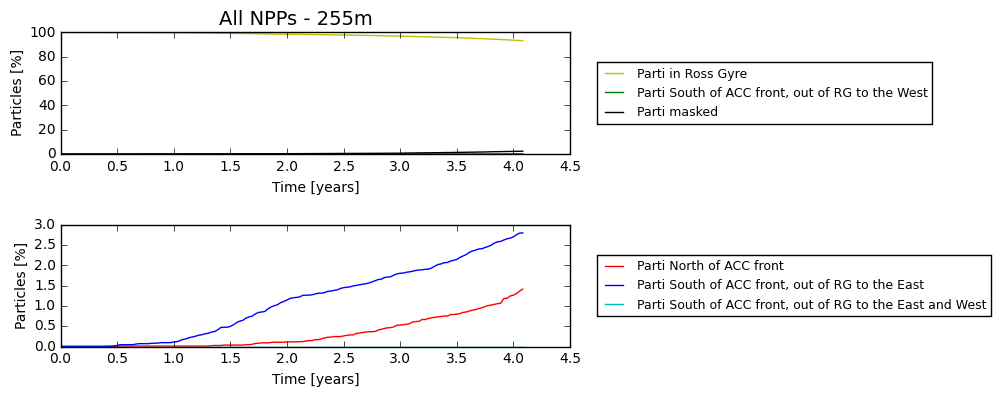

In [20]:
plot_1NPP(npts = sum_zones['Z1'][0], title = 'All NPPs - 255m', dictionary_of_zones=sum_zones)

In [21]:
sum_zones['Z1'][-1]

18627.0

In [22]:
sum_zones['Z2'][-1]

283.0

In [23]:
sum_zones['Z3'][-1]

39.0

In [24]:
sum_zones['Z4'][-1]

560.0

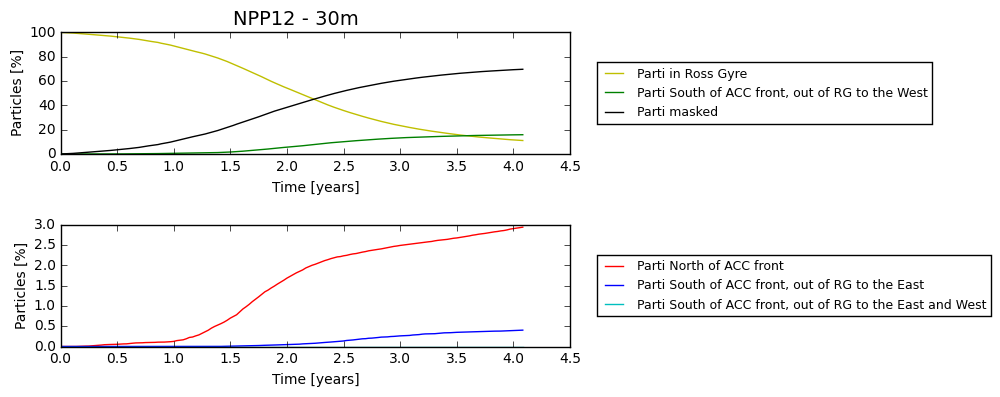

In [17]:
plot_1NPP(npts = Sum_Zones['Z1'][0], title = 'NPP' + NPP + ' - 30m', dictionary_of_zones=Sum_Zones)

With no dictionary

In [ ]:
npp = ['01', '02']#, '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
n = 1
#FIG = plt.figure(figsize=(14,14))
for NPP in npp:
    print 'NPP'+ NPP + ' :'
    Z1 = pickle_load('NPP' + NPP + '_Z1', path, verbose=False)
    Z2 = pickle_load('NPP' + NPP + '_Z2', path, verbose=False)
    Z3 = pickle_load('NPP' + NPP + '_Z3', path, verbose=False)
    Z4 = pickle_load('NPP' + NPP + '_Z4', path, verbose=False)
    Z5 = pickle_load('NPP' + NPP + '_Z5', path, verbose=False)
    dead = pickle_load('NPP' + NPP + '_dead', path, verbose=False)
    dead = dead-dead[0]
    
    Z1_crop = Z1[-148:]
    Z2_crop = Z2[-148:] 
    Z3_crop = Z3[-148:] 
    Z4_crop = Z4[-148:] 
    Z5_crop = Z5[-148:] 
    dead_crop = dead[-148:] 

    #plt.subplot(3,4,n)
    n+=1
    plot_1NPP(npts = Z1[0], title = 'NPP' + NPP + ' - 30m')
    print ''
#ax1.legend(bbox_to_anchor=(1.04,0.5), loc='lower center', fontsize=9)
#ax2.legend(bbox_to_anchor=(1.04,0.5), loc='lower center', fontsize=9)
#FIG.suptitle(title, fontsize=14)
#FIG.subplots_adjust(bottom=0.6)
#FIG.tight_layout()

## 30 m


Total nb of particles that stay in the Ross Gyre : 9.42424242424 %
Total nb of particles that go North : 3.23232323232 %
Total nb of particles that go West : 14.6363636364 %
Total nb of particles that go East : 0.464646464646 %
Total nb of particles that go East then West : 0.0 %
Total number of particles : 9900.0


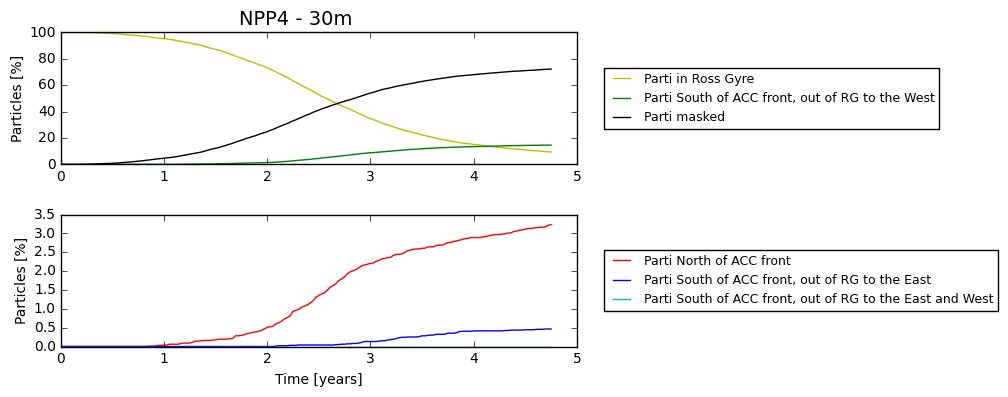

In [21]:
plot_1NPP(npts = Z1[0], title = 'NPP4 - 30m')

***

## 725 m


Total nb of particles that stay in the Ross Gyre : 28.5425685426 %
Total nb of particles that go North : 1.84704184704 %
Total nb of particles that go West : 26.810966811 %
Total nb of particles that go East : 0.0 %
Total nb of particles that go East then West : 0.0 %
Total number of particles : 6930.0


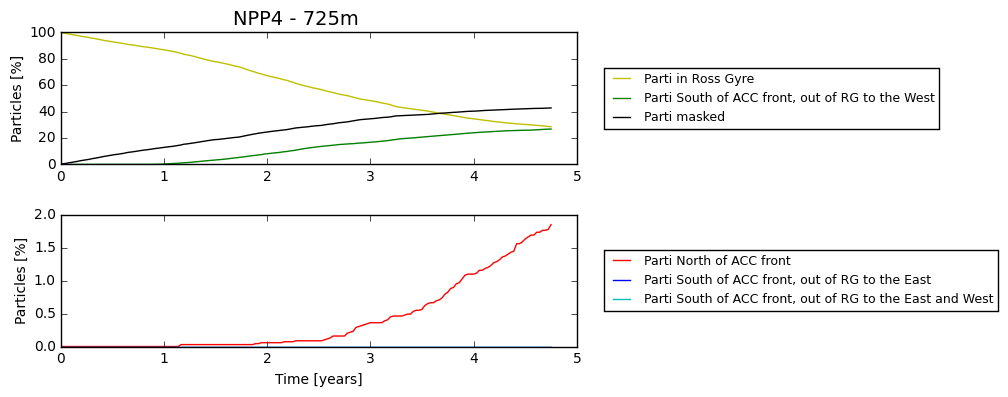

In [47]:
plot_1NPP(npts = Z1[0], title = 'NPP4 - 725m')

***

### 1st function to plot

In [69]:
time = (np.arange(xround.shape[0])*10)/360.
def plot1(title):
    #plt.plot(time, evo_zone1*100/npts, '-m')
    time = (np.arange(len(evo_zone2))*10)/360.
    
    plt.plot(time, evo_zone2*100./npts, '-r', label='Parti North of ACC front')
    plt.plot(time, evo_zone3*100./npts, '-g', label='Parti South of ACC front, out of RG to the West')
    plt.plot(time, evo_zone4*100./npts, '-b', label='Parti South of ACC front, out of RG to the East')
    plt.plot(time, evo_zone5*100./npts, '-c', label='Parti South of ACC front, out of RG to the East and West')
    plt.plot(time, total*100./npts, '-k', label='Parti in Ross Gyre')
    
    #plt.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    plt.ylabel('Particles [%]')
    plt.title(title)

## Make figure with several NPP

IOError: [Errno 2] No such file or directory: '/data/ebent/Particle_analysis/30m/NPP4_evo_zone1.npy'

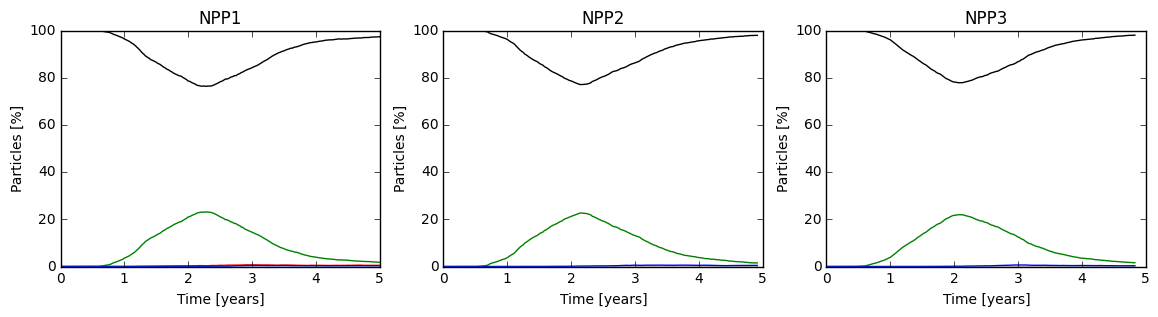

In [70]:
fig = plt.figure(figsize=(14,14))
i = 1
for NPP in NPPs:
    evo_zone1 = pickle_load(NPP + '_evo_zone1', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone2 = pickle_load(NPP + '_evo_zone2', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone3 = pickle_load(NPP + '_evo_zone3', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone4 = pickle_load(NPP + '_evo_zone4', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone5 = pickle_load(NPP + '_evo_zone5', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    total = np.ones(evo_zone2.shape[0])*10000
    total = total-evo_zone2-evo_zone3-evo_zone4-evo_zone5
    
    plt.subplot(4,3,i)
    plot1(NPP)
    i+=1
fig.tight_layout

***

# Test cells

In [38]:
Ind_parti_north = pickle_load('Ind_parti_north', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Ind_parti_north.npy')


In [140]:
NPP = 'NPP12'
DEP = pickle_load(NPP + '_DEP', Path)
LAT = pickle_load(NPP + '_LAT', Path)
LON = pickle_load(NPP + '_LON', Path)

zround = pickle_load(NPP + '_zround', Path)
yround = pickle_load(NPP + '_yround', Path)
xround = pickle_load(NPP + '_xround', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_xround.npy')


In [ ]:
N = '02'
i = 137
tmp = np.squeeze(np.array(np.ma.where(southern_front[yround[:,Ind_parti_north[N][i]], xround[:,Ind_parti_north[N][i]]]==0)))

# Actual code

In [18]:
Path= '/data/ebent/Octopus/output/255m_line_RG/'
npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [36]:
# Loop to save the p indexes of particles that go north thanks to function count_in_zones
npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

Ind_parti_north = {}

for NPP in npp:
    #print 'NPP', NPP
    zround = pickle_load('NPP' + NPP + '_zround', Path, verbose=False)
    yround = pickle_load('NPP' + NPP + '_yround', Path, verbose=False)
    xround = pickle_load('NPP' + NPP + '_xround', Path, verbose=False)

    in_RG, to_east, to_north, to_west, to_west_east = count_in_zones(NPP, xround, yround, zround)

    Ind_parti_north[NPP] = to_north
    
pickle_save('Ind_parti_north', Path, Ind_parti_north)

01

NPP01 :

Particles that stay in the Ross Gyre : 9548
Particles that go North : 146
Particles that go West : 15
Particles that go East : 288
Particles that go East then West : 0
Particles that are masked : 3
Total number of particles not dead : 9997
len to north : 146
02

NPP02 :

Particles that stay in the Ross Gyre : 9564
Particles that go North : 137
Particles that go West : 24
Particles that go East : 272
Particles that go East then West : 0
Particles that are masked : 3
Total number of particles not dead : 9997
len to north : 137
03

NPP03 :

Particles that stay in the Ross Gyre : 9584
Particles that go North : 148
Particles that go West : 18
Particles that go East : 247
Particles that go East then West : 0
Particles that are masked : 3
Total number of particles not dead : 9997
len to north : 148
04

NPP04 :

Particles that stay in the Ross Gyre : 9655
Particles that go North : 125
Particles that go West : 22
Particles that go East : 195
Particles that go East then West : 0
Par

In [36]:
# Loop to save the t indexes of particles that go north thanks to index of p we selected above, use of southern_front

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
T_step_parti_north = {}

for NPP in npp:
    zround = pickle_load('NPP' + NPP + '_zround', Path, verbose=False)
    yround = pickle_load('NPP' + NPP + '_yround', Path, verbose=False)
    xround = pickle_load('NPP' + NPP + '_xround', Path, verbose=False)
    #print 'NPP', NPP
    t_to_north = []
    
    for i in range(len(Ind_parti_north[NPP])):
        #print i
        tmp = np.squeeze(np.array(np.ma.where(southern_front[yround[:,Ind_parti_north[NPP][i]], xround[:,Ind_parti_north[NPP][i]]]==0)))
        if tmp.size == 1:
            t_to_north.append(np.int_(tmp))
        else:
            t_to_north.append(tmp[0])
                                  
    T_step_parti_north[NPP] = t_to_north
    #print T_step_parti_north[NPP]

pickle_save('T_step_parti_north', Path, T_step_parti_north)

NPP 01
NPP 02
NPP 03
NPP 04
NPP 05
NPP 06
NPP 07
NPP 08
NPP 09
NPP 10
NPP 11
NPP 12
('saved at : ', '/data/ebent/Octopus/output/255m_line_RG/T_step_parti_north.npy')


In [136]:
# Check if lists containing indexes p and t have same length = nb of parti that go north
for NPP in npp:
    print len(T_step_parti_north[NPP]), len(Ind_parti_north[NPP])

146 146
137 137
148 148
125 125
125 125
124 124
115 115
107 107
127 127
134 134
147 147
161 161


In [16]:
T_step_parti_north = pickle_load('T_step_parti_north', Path)
Ind_parti_north = pickle_load('Ind_parti_north', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/T_step_parti_north.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Ind_parti_north.npy')


In [20]:
# Make one list with all depths of crossing for all NPPs
import itertools
DEP_cross = []
LON_cross = []
TIME_cross = []
for NPP in npp:
    #print 'NPP', NPP
    DEP = pickle_load('NPP' + NPP + '_DEP', Path, verbose=False)
    DEP_cross.append(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    
    LON = pickle_load('NPP' + NPP + '_LON', Path, verbose=False)
    LON_cross.append(LON[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    
    TIME_cross.append(T_step_parti_north[NPP])
    
DEP_cross = list(itertools.chain(*DEP_cross))
LON_cross = list(itertools.chain(*LON_cross))
TIME_cross = list(itertools.chain(*TIME_cross))

In [237]:
for NPP in npp:
    DEP = pickle_load('NPP' + NPP + '_DEP', Path, verbose=False)
    LON = pickle_load('NPP' + NPP + '_LON', Path, verbose=False)

    print 'Mean longitude of NPP', NPP, ':', np.mean(LON[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    print 'Mean depth of NPP', NPP, ':', np.mean(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    #print 'Max of NPP', NPP, ':', np.max(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    #plt.figure()
    #plt.hist(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]], bins=15)#, weights=DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]]*100/len(T_step_parti_north[NPP])) 

Mean longitude of NPP 01 : 218.651487586
Mean depth of NPP 01 : 537.188356164
Mean longitude of NPP 02 : 217.776374316
Mean depth of NPP 02 : 566.081318431
Mean longitude of NPP 03 : 218.864046664
Mean depth of NPP 03 : 613.131598395
Mean longitude of NPP 04 : 218.67590625
Mean depth of NPP 04 : 571.391875
Mean longitude of NPP 05 : 218.3168125
Mean depth of NPP 05 : 600.75725
Mean longitude of NPP 06 : 219.08108619
Mean depth of NPP 06 : 566.944430444
Mean longitude of NPP 07 : 219.740625
Mean depth of NPP 07 : 629.496331522
Mean longitude of NPP 08 : 220.080370181
Mean depth of NPP 08 : 589.747444509
Mean longitude of NPP 09 : 218.128521777
Mean depth of NPP 09 : 562.582861713
Mean longitude of NPP 10 : 220.649384911
Mean depth of NPP 10 : 621.277518657
Mean longitude of NPP 11 : 221.31725659
Mean depth of NPP 11 : 527.347151361
Mean longitude of NPP 12 : 221.351489713
Mean depth of NPP 12 : 568.361170419


<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x24394490>>

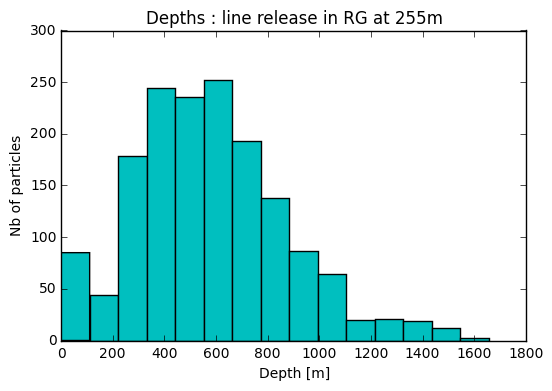

In [249]:
fig = plt.figure()
plt.hist(DEP_cross, bins=15, color='c')
plt.title('Depths : line release in RG at 255m', )
plt.xlabel('Depth [m]')
plt.ylabel('Nb of particles')
fig.tight_layout

<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x427cca50>>

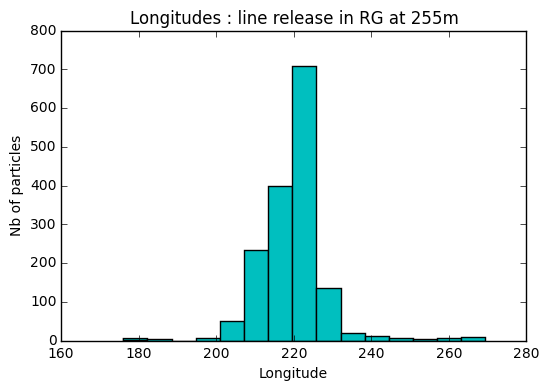

In [265]:
fig = plt.figure()
plt.hist(LON_cross, bins=15, color='c')
plt.title('Longitudes : line release in RG at 255m', )
plt.xlabel('Longitude')
plt.ylabel('Nb of particles')
fig.tight_layout

<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x22f60c10>>

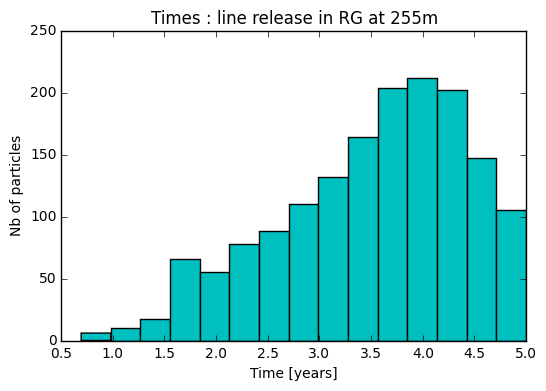

In [68]:
fig = plt.figure()

TIME_cross_yr = np.array(TIME_cross, dtype=np.float64)*10/360 
plt.hist(TIME_cross_yr, bins=15, color='c')
plt.title('Times : line release in RG at 255m', )
plt.xlabel('Time [years]')
plt.ylabel('Nb of particles')
fig.tight_layout

# Months of crossing

## This makes a list of 5yrs filled with the info on which month it is

In [27]:
import calendar

In [31]:
for name in calendar.month_abbr:
    print name


Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec


In [38]:
MONTHS = calendar.month_abbr

In [64]:
MAY = []
JUL = []
AUG = []
OCT = []
DEC = []
JAN = []
MAR = []

for i in range(1,32):
    MAY.append('MAY')
    JUL.append('JUL')
    AUG.append('AUG')
    OCT.append('OCT')
    DEC.append('DEC')
    JAN.append('JAN')
    MAR.append('MAR')

In [65]:
JUN = []
SEP = []
NOV = []

for i in range(1,31):
    JUN.append('JUN')
    SEP.append('SEP')
    NOV.append('NOV')

In [66]:
FEV = []
for i in range(1,29):
    FEV.append('FEV')

In [67]:
beg_APR = []
end_APR = []

for i in range(1,6):
    beg_APR.append('APR')
    
for i in range(6,31):
    end_APR.append('APR')

In [68]:
Year = []
Year = [beg_APR, MAY, JUN, JUL, AUG, SEP, OCT, NOV, DEC, JAN, FEV, MAR, end_APR]

In [69]:
Year_1_list = list(itertools.chain(*Year))

In [70]:
Five_Years = []
for i in range(5):
    Five_Years.append(Year_1_list)

In [71]:
Five_Years_1_list = list(itertools.chain(*Five_Years))

In [72]:
len(Five_Years_1_list)

1825

## Searchs the month that correspond to the time in index

In [73]:
analysis = []
for i in range(len(TIME_cross)):
    analysis.append(Five_Years_1_list[np.array(TIME_cross[i])*10]) # multiply by ten as it is output every 10 days

In [74]:
y = ['APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'JAN', 'FEV', 'MAR']

for y in y:
    print y 
    print np.squeeze(np.array(np.where(np.array(analysis) == y))).size
    print ''

APR
103

MAY
134

JUN
129

JUL
112

AUG
135

SEP
129

OCT
115

NOV
154

DEC
133

JAN
202

FEV
127

MAR
123



In [75]:
from collections import Counter

num = Counter(analysis)

In [76]:
x = list(num.values())
y = list(num.keys())

In [77]:
num.keys()

['JAN',
 'MAR',
 'AUG',
 'SEP',
 'APR',
 'JUN',
 'JUL',
 'FEV',
 'MAY',
 'NOV',
 'DEC',
 'OCT']

In [78]:
X = list(x)
Y = list(y)

In [81]:
for i in range(12):
    if y[i] == 'JAN':
        Y[0] = y[i]
        X[0] = x[i]
    if y[i] == 'FEV':
        Y[1] = y[i]
        X[1] = x[i]
    if y[i] == 'MAR':
        Y[2] = y[i]
        X[2] = x[i]
    if y[i] == 'APR':
        Y[3] = y[i]
        X[3] = x[i]
    if y[i] == 'MAY':
        Y[4] = y[i]
        X[4] = x[i]
    if y[i] == 'JUN':
        Y[5] = y[i]
        X[5] = x[i]
    if y[i] == 'JUL':
        Y[6] = y[i]
        X[6] = x[i]
    if y[i] == 'AUG':
        Y[7] = y[i]
        X[7] = x[i]
    if y[i] == 'SEP':
        Y[8] = y[i]
        X[8] = x[i]
    if y[i] == 'OCT':
        Y[9] = y[i]
        X[9] = x[i]
    if y[i] == 'NOV':
        Y[10] = y[i]
        X[10] = x[i]
    if y[i] == 'DEC':
        Y[11] = y[i]
        X[11] = x[i]

In [80]:
for i in range(12):
    print i, Y[i]

0 JAN
1 FEV
2 MAR
3 APR
4 MAY
5 JUN
6 JUL
7 AUG
8 SEP
9 OCT
10 NOV
11 DEC


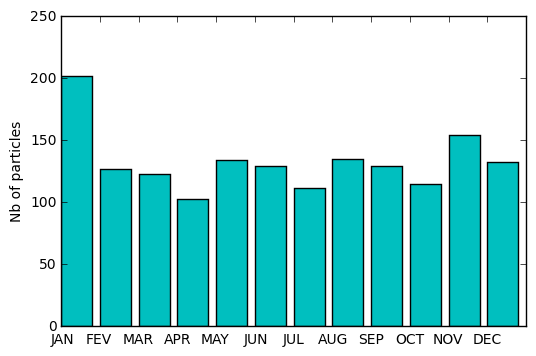

In [251]:
x_coordinates = np.arange(len(num.keys()))
plt.bar(x_coordinates, X, color='c')
x_coordinates = np.arange(len(num.keys()))+0.5
plt.xticks(x_coordinates, Y)
plt.ylabel('Nb of particles')